In [1]:
!pip install pfhedge


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io

In [20]:
from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption

stock = BrownianStock(cost=1e-4, mu=0.05)
derivative = EuropeanOption(stock, maturity=1)

derivative

EuropeanOption(
  strike=1., maturity=1
  (underlier): BrownianStock(sigma=0.2000, mu=0.0500, cost=1.0000e-04, dt=0.0040)
)

In [26]:
from pfhedge.nn import BlackScholes
from pfhedge.nn import Clamp
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron
from pfhedge.nn import EntropicRiskMeasure

new_loss = EntropicRiskMeasure(a=1)

model = MultiLayerPerceptron()
hedger = Hedger(model, inputs=["log_moneyness", "expiry_time", "volatility", "prev_hedge"], criterion=new_loss)

hedger

Hedger(
  inputs=['log_moneyness', 'expiry_time', 'volatility', 'prev_hedge']
  (model): MultiLayerPerceptron(
    (0): LazyLinear(in_features=0, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Identity()
  )
  (criterion): EntropicRiskMeasure()
)

In [27]:
loss_obs = hedger.fit(derivative, n_epochs=200)

Loss=0.0482: 100%|██████████| 200/200 [01:43<00:00,  1.94it/s]


In [6]:
loss_obs

[0.0,
 0.0,
 0.0,
 0.0,
 -0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.0,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.476837158203125,
 -0.476837158203125,
 -0.476837158203125,
 -0.476837158203125,
 -1.430511474609375,
 -5.7220458984375,
 -251.77001953125,
 5180999.5,
 -169.27719116210938,
 -4.76837158203125,
 -3.337860107421875,
 -1.430511474609375,
 -0.95367431640625,
 -0.95367431640625,
 -0.95367431640625,
 -0.476837158203125,
 -0.95367431640625,
 -0.95367431640625,
 -0.95367431640625,
 -0.95367431640625,
 -0.476837158203125,
 -0.47683

(-6000.0, 100.0)

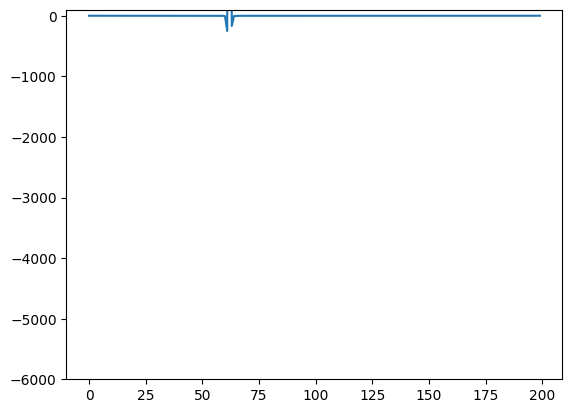

In [7]:
plt.plot(loss_obs)
plt.ylim((-6000,100))

In [28]:
price = hedger.price(derivative)
price

tensor(0.0491)

In [24]:
class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]

        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])

        return self.clamp(prev_hedge, min=min, max=max)


model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs())

hedger.fit(derivative, n_epochs=200)

Loss=0.0629: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


[0.0835733413696289,
 0.08242368698120117,
 0.08244848251342773,
 0.08246088027954102,
 0.08198022842407227,
 0.0801849365234375,
 0.07982254028320312,
 0.08075904846191406,
 0.08012056350708008,
 0.0801992416381836,
 0.08107614517211914,
 0.07836771011352539,
 0.07921600341796875,
 0.07809686660766602,
 0.07764339447021484,
 0.0768442153930664,
 0.07733821868896484,
 0.07700586318969727,
 0.07634162902832031,
 0.0772709846496582,
 0.07554912567138672,
 0.07475805282592773,
 0.0745859146118164,
 0.07485294342041016,
 0.07472944259643555,
 0.07447624206542969,
 0.07482147216796875,
 0.07354974746704102,
 0.07342195510864258,
 0.07738161087036133,
 0.07311677932739258,
 0.07584810256958008,
 0.0744485855102539,
 0.07341766357421875,
 0.07445001602172852,
 0.07338333129882812,
 0.07350587844848633,
 0.07367801666259766,
 0.0719752311706543,
 0.07466554641723633,
 0.07328939437866211,
 0.07437276840209961,
 0.07239007949829102,
 0.07357263565063477,
 0.07107925415039062,
 0.071186065673828

In [25]:
price = hedger.price(derivative)
price

tensor(0.0630)

In [11]:
from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption
from pfhedge.nn import BlackScholes
from pfhedge.nn import Hedger

In [17]:
torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model = BlackScholes(derivative)
hedger = Hedger(model, model.inputs())

# Fit and price
price = hedger.price(derivative, n_paths=10000)
print(f"Price={price:.5e}")

Price=8.02164e-02
